#### Setting up the dependencies

In [65]:
# !pip install geopy
# !pip install geopandas
# !pip install descartes

In [20]:
import pandas as pd
import numpy as np
import copy
import random
import geopandas as gpd
import matplotlib.pyplot as plt
import weighted_kmeans as wk

from geopy.distance import great_circle

#### Importing data

Centroids

In [27]:
VTD_centers = pd.read_csv('./data/centroids.csv').iloc[:, 1:]

In [28]:
VTD_centers.head()

,id,Latitude,Longitude
0,0,36.071695,-79.419765
1,1,36.091723,-79.418955
2,2,36.094599,-79.448652
3,3,36.078980,-79.398244
4,4,36.088832,-79.468159


Population, black population and democratic votes per VTD

In [29]:
shapefile = gpd.read_file("./data/NC_VTD.shp")

In [30]:
population = shapefile.TOTPOP.values
black_population = shapefile.BPOP.values

In [31]:
dem_votes = shapefile.EL16G_GV_D.values
total_votes = shapefile.EL16G_GV_T.values

In [32]:
print(type(population))
print(len(population))

<class 'numpy.ndarray'>
2692


In [34]:
shapefile.iloc[:3, :].to_file("./data/demo_NC_VTD.shp")

## Demonstration of Weighted K-Means

Parameters: `alpha_pop` = 0.9, `beta` = 0.65, `weight_by_pop` = True, `weight_by_race` = False, `weight_by_dem` = False.

In [23]:
np.random.seed(0)

km = wk.Weighted_K_Means(tolerance = 0.0001, weight_by_pop = True, weight_by_race = False, weight_by_dem = False)
clusters, clusters_by_ids, convergence = km.fit(VTD_centers, population, black_population, 
                                                                dem_votes, total_votes, 
                                                                beta = 0.65, alpha_pop = 0.9)

error = wk.eval_error(clusters_by_ids, population, black_population, dem_votes, total_votes)
error

optimal after 19 iterations


11.759051897969762

## Plotting the proposed redistricting map

In [24]:
cluster_assignment = np.array([[idx, key] for key in clusters_by_ids.keys() for idx in clusters_by_ids[key]])
cluster_assignment = cluster_assignment[cluster_assignment[:, 0].argsort()]

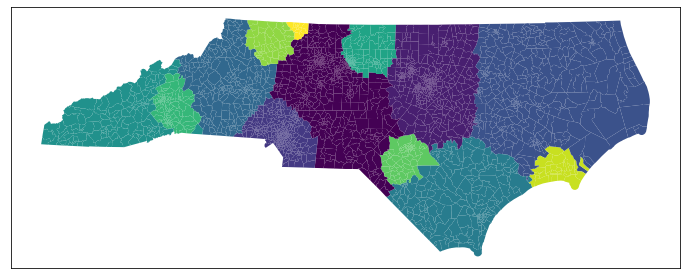

In [25]:
plt.rcParams['figure.figsize'] = (12, 5)
shapefile['clusters'] = cluster_assignment[:, 1]
shapefile.plot(column='clusters')
plt.xticks([])
plt.yticks([])
plt.show()

Save the shapefile with a column `clusters` indicatign the proposed redistricting

In [49]:
# save the shapefile
# shapefile.to_file("../NC_VTD/NC_VTD_and_KMeans.shp")

Let's compare our solution to the old redistricting plan by Republicans

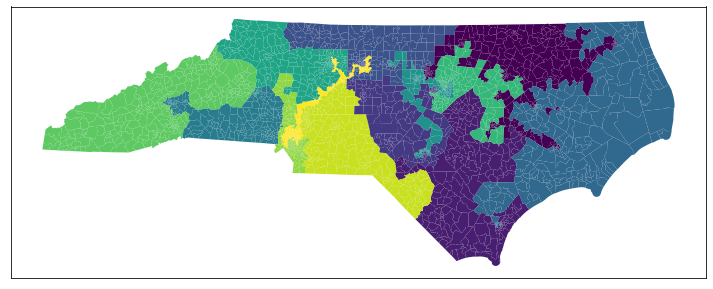

In [20]:
shapefile.plot(column='oldplan')
plt.rcParams['figure.figsize'] = [25, 5]
plt.xticks([])
plt.yticks([])
plt.show()

## Projecting the maps into 2030-2050

### Population growth projections by county
Source paper: https://www.nature.com/articles/sdata20195 

Source GitHub with pre-processing code: https://github.com/mathewhauer/county_projections_official

Data directly available here as `SSP_asrc.csv`: https://osf.io/uh5sj/

In [56]:
population_NC = pd.read_csv('./data/demo_SSP_asrc.csv')

In [57]:
population_NC.head()

,YEAR,SEX,STATE,COUNTY,GEOID,RACE,AGE,SSP1,SSP2,SSP3,SSP4,SSP5
0,2030,1,37,1,37001,1,1,2298.567576,2365.246222,1845.482957,2041.997513,2874.695705
1,2030,1,37,1,37001,1,2,2505.030509,2558.387080,2139.141110,2314.580357,2981.359765
2,2030,1,37,1,37001,1,3,2750.473001,2788.674255,2483.075820,2611.909144,3109.050044
3,2030,1,37,1,37001,1,4,3387.816089,3406.023579,3197.291040,3283.006450,3632.765514
4,2030,1,37,1,37001,1,5,2944.408754,2941.419656,2893.879843,2940.730599,2987.698350


STATE column is FIPS code of state. NC is 37.

COUNTY column is FIPS code of each county

GEOID column is 'STATE' + 'COUNTY' (e.g. 37 and 001 make 37001) and can be mappen to 'County' columns in shapefile

Aggregate to county level (disregard sex, race and age)

In [10]:
population_NC_total = population_NC.groupby(['YEAR', 'GEOID']).sum()[['SSP1', 'SSP2', 'SSP3', 'SSP4', 'SSP5']].reset_index()

In [11]:
population_NC_total[population_NC_total['YEAR'] == 2020].head()

,YEAR,GEOID,SSP1,SSP2,SSP3,SSP4,SSP5
0,2020,37001,166379.519822,165851.076670,162485.439219,164825.992922,169321.296865
1,2020,37003,37549.759714,37393.041727,36689.441353,37212.670132,38119.014812
2,2020,37005,10572.668139,10516.041247,10324.368554,10470.450086,10714.008471
3,2020,37007,24813.336782,24725.748149,24244.673872,24603.546909,25220.908463
4,2020,37009,26644.545415,26510.971022,26019.517202,26390.475746,27018.512599


Comparing the projections to the population dataset we had for 2010 (or 2015?), we see that the numbers are in the same order of magnitude (+/- 2%) which means we are on the right path. Now we can look at their projections.

Let's retrieve the population in 2030 in each VTD under several scenarios: high, middle and low growth rate

In [12]:
#change type of integer so that merging is possible
shapefile['County'] = shapefile['County'].astype(int)

#count number of VTDs in each county
shapefile = pd.merge(shapefile, shapefile.groupby('County').count()['VTD'].reset_index(), on = 'County')
shapefile = shapefile.rename(columns = {'VTD_x': 'VTD', 'VTD_y': 'VTD_per_county'})

In [13]:
NC_high = population_NC_total[population_NC_total['YEAR'] == 2030][['GEOID', 'SSP5']]
shapefile_merged = pd.merge(shapefile, NC_high, how='left', left_on='County', right_on='GEOID')
population_2030_high = (shapefile_merged['SSP5']/shapefile_merged['VTD_per_county']).values

NC_mid = population_NC_total[population_NC_total['YEAR'] == 2030][['GEOID', 'SSP2']]
shapefile_merged = pd.merge(shapefile, NC_mid, how='left', left_on='County', right_on='GEOID')
population_2030_mid = (shapefile_merged['SSP2']/shapefile_merged['VTD_per_county']).values

NC_low = population_NC_total[population_NC_total['YEAR'] == 2030][['GEOID', 'SSP3']]
shapefile_merged = pd.merge(shapefile, NC_low, how='left', left_on='County', right_on='GEOID')
population_2030_low = (shapefile_merged['SSP3']/shapefile_merged['VTD_per_county']).values

In [14]:
population_2030_high

array([5346.26012039, 5346.26012039, 5346.26012039, ..., 1562.47695995,
       1562.47695995, 1562.47695995])

Now, Let's re-run our Weighted K-Means while setting the seed to make our projections more comparable

### Current population

optimal after 19 iterations


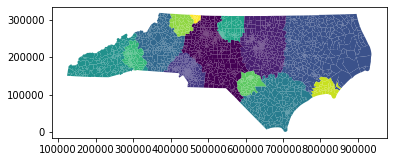

In [154]:
#for replicability
np.random.seed(0)

km = Weighted_K_Means(tolerance = 0.0001, weight_by_pop = True, weight_by_race = False, weight_by_dem = False)
clusters, clusters_by_ids, convergence = km.fit(VTD_centers, population, black_population, 
                                                                dem_votes, total_votes, 
                                                                beta = 0.65, alpha_pop = 0.9)

cluster_assignment = np.array([[idx, key] for key in clusters_by_ids.keys() for idx in clusters_by_ids[key]])
cluster_assignment = cluster_assignment[cluster_assignment[:, 0].argsort()]

shapefile['clusters'] = cluster_assignment[:, 1]
shapefile.plot(column='clusters')
plt.show()

### Population in 2030 under high population growth scenario

optimal after 32 iterations


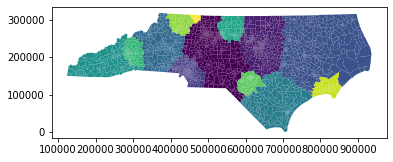

In [15]:
np.random.seed(0)

km = Weighted_K_Means(tolerance = 0.0001, weight_by_pop = True, weight_by_race = False, weight_by_dem = False)
clusters, clusters_by_ids, convergence = km.fit(VTD_centers, population_2030_high, black_population, 
                                                                dem_votes, total_votes, 
                                                                beta = 0.65, alpha_pop = 0.9)

cluster_assignment = np.array([[idx, key] for key in clusters_by_ids.keys() for idx in clusters_by_ids[key]])
cluster_assignment = cluster_assignment[cluster_assignment[:, 0].argsort()]

shapefile['clusters'] = cluster_assignment[:, 1]
shapefile.plot(column='clusters')
plt.show()

### Population in 2030 under medium population growth scenario

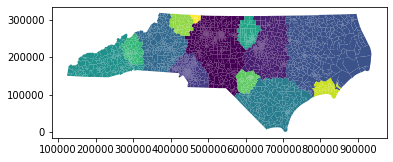

In [16]:
np.random.seed(0)

km = Weighted_K_Means(tolerance = 0.0001, weight_by_pop = True, weight_by_race = False, weight_by_dem = False)
clusters, clusters_by_ids, convergence = km.fit(VTD_centers, population_2030_mid, black_population, 
                                                                dem_votes, total_votes, 
                                                                beta = 0.65, alpha_pop = 0.9)

cluster_assignment = np.array([[idx, key] for key in clusters_by_ids.keys() for idx in clusters_by_ids[key]])
cluster_assignment = cluster_assignment[cluster_assignment[:, 0].argsort()]

shapefile['clusters'] = cluster_assignment[:, 1]
shapefile.plot(column='clusters')
plt.show()

### Population in 2030 under low population growth scenario

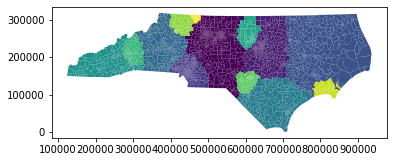

In [17]:
np.random.seed(0)

km = Weighted_K_Means(tolerance = 0.0001, weight_by_pop = True, weight_by_race = False, weight_by_dem = False)
clusters, clusters_by_ids, convergence = km.fit(VTD_centers, population_2030_low, black_population, 
                                                                dem_votes, total_votes, 
                                                                beta = 0.65, alpha_pop = 0.9)

cluster_assignment = np.array([[idx, key] for key in clusters_by_ids.keys() for idx in clusters_by_ids[key]])
cluster_assignment = cluster_assignment[cluster_assignment[:, 0].argsort()]

shapefile['clusters'] = cluster_assignment[:, 1]
shapefile.plot(column='clusters')
plt.show()

Now, let's remind ourselves that we used the population figure on a county level that we split equally between VTDs in each county. On average, one county cosists of more than 10 VTDs. An alternative approach would be to calculate the projected growth rate per county and apply it to the current population of each VTD in that county. Let's pursue this approach here and see how it changes the results. Let's focus on the SSP5, most aggressive growth figures 

In [23]:
old_county_population = shapefile.groupby('County').sum()['TOTPOP'].values

In [22]:
new_county_population = NC_high['SSP5'].values

In [24]:
len(old_county_population) == len(new_county_population)

True

In [29]:
growth_factor = 1 + (new_county_population - old_county_population)/old_county_population
growth_factor[:5]

array([1.27350024, 1.0280526 , 0.91372295, 0.8815064 , 0.96449296])

In [36]:
NC_high['growth_factor'] = growth_factor

In [46]:
shapefile_merged = pd.merge(shapefile, NC_high.iloc[:, [0, 2]], left_on = 'County', right_on = 'GEOID')
population_2030_high = (shapefile_merged['TOTPOP'] * shapefile_merged['growth_factor']).values

#just for comparison
shapefile_merged['population_2030_high'] = shapefile_merged['TOTPOP'] * shapefile_merged['growth_factor']
shapefile_merged.loc[:5, ['County', 'TOTPOP', 'growth_factor', 'population_2030_high']]

,County,TOTPOP,growth_factor,population_2030_high
0,37001,1973,1.2735,2512.615968
1,37001,3391,1.2735,4318.439304
2,37001,2744,1.2735,3494.484651
3,37001,4468,1.2735,5689.999059
4,37001,2038,1.2735,2595.393483
5,37001,2455,1.2735,3126.443082


optimal after 31 iterations


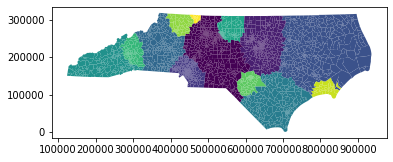

In [48]:
np.random.seed(0)

km = Weighted_K_Means(tolerance = 0.0001, weight_by_pop = True, weight_by_race = False, weight_by_dem = False)
clusters, clusters_by_ids, convergence = km.fit(VTD_centers, population_2030_high, black_population, 
                                                                dem_votes, total_votes, 
                                                                beta = 0.65, alpha_pop = 0.9)

cluster_assignment = np.array([[idx, key] for key in clusters_by_ids.keys() for idx in clusters_by_ids[key]])
cluster_assignment = cluster_assignment[cluster_assignment[:, 0].argsort()]

shapefile['clusters'] = cluster_assignment[:, 1]
shapefile.plot(column='clusters')
plt.show()

This looks very similar to the plot we got before hence I did not proceed with this approach

Let's do this for 2050

### Population in 2050 with high population growth scenario

In [50]:
NC_high = population_NC_total[population_NC_total['YEAR'] == 2050][['GEOID', 'SSP5']]
shapefile_merged = pd.merge(shapefile, NC_high, how='left', left_on='County', right_on='GEOID')
population_2050_high = (shapefile_merged['SSP5']/shapefile_merged['VTD_per_county']).values

NC_mid = population_NC_total[population_NC_total['YEAR'] == 2050][['GEOID', 'SSP2']]
shapefile_merged = pd.merge(shapefile, NC_mid, how='left', left_on='County', right_on='GEOID')
population_2050_mid = (shapefile_merged['SSP2']/shapefile_merged['VTD_per_county']).values

NC_low = population_NC_total[population_NC_total['YEAR'] == 2050][['GEOID', 'SSP3']]
shapefile_merged = pd.merge(shapefile, NC_low, how='left', left_on='County', right_on='GEOID')
population_2050_low = (shapefile_merged['SSP3']/shapefile_merged['VTD_per_county']).values

optimal after 28 iterations


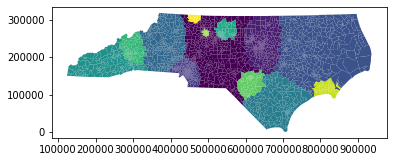

In [51]:
np.random.seed(0)

km = Weighted_K_Means(tolerance = 0.0001, weight_by_pop = True, weight_by_race = False, weight_by_dem = False)
clusters, clusters_by_ids, convergence = km.fit(VTD_centers, population_2050_high, black_population, 
                                                                dem_votes, total_votes, 
                                                                beta = 0.65, alpha_pop = 0.9)

cluster_assignment = np.array([[idx, key] for key in clusters_by_ids.keys() for idx in clusters_by_ids[key]])
cluster_assignment = cluster_assignment[cluster_assignment[:, 0].argsort()]

shapefile['clusters'] = cluster_assignment[:, 1]
shapefile.plot(column='clusters')
plt.show()

### Population in 2050 with medium population growth scenario

optimal after 29 iterations


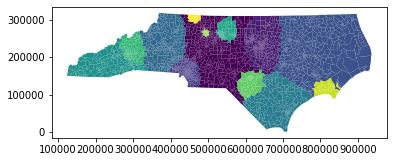

In [52]:
np.random.seed(0)

km = Weighted_K_Means(tolerance = 0.0001, weight_by_pop = True, weight_by_race = False, weight_by_dem = False)
clusters, clusters_by_ids, convergence = km.fit(VTD_centers, population_2050_mid, black_population, 
                                                                dem_votes, total_votes, 
                                                                beta = 0.65, alpha_pop = 0.9)

cluster_assignment = np.array([[idx, key] for key in clusters_by_ids.keys() for idx in clusters_by_ids[key]])
cluster_assignment = cluster_assignment[cluster_assignment[:, 0].argsort()]

shapefile['clusters'] = cluster_assignment[:, 1]
shapefile.plot(column='clusters')
plt.show()